used the code in this [link](https://github.com/TinyVolt/normalizing-flows) and modify it for mnist dataset

In [1]:
import torch
import torch.nn as nn
from torch.distributions.uniform import Uniform


# Section 1: Preprocess
class Preprocess(nn.Module):
    def __init__(self):
        super(Preprocess, self).__init__()

    def forward(self, x, reverse=False):
        device = x.device
        if reverse:
            return (x.sigmoid() - 0.05) / 0.9
        x += Uniform(0.0, 1.0).sample(x.size()).to(device)
        x = 0.05 + 0.9 * (x / 4.0)
        z = torch.log(x) - torch.log(1 - x)
        log_det_jacobian = -x.log() - (1 - x).log() + torch.tensor(0.9 / 4).log().to(device)
        return z, log_det_jacobian


class WeightNormConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, bias=bias)
        )

    def forward(self, x):
        return self.conv(x)


class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, 1, stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, 3, stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, 1, stride=1, padding=0),
        )

    def forward(self, x):
        return x + self.block(x)


class ResNet(nn.Module):
    def __init__(self, in_channel=1, out_channel=2, intermediate_channel=128, num_blocks=4):
        super(ResNet, self).__init__()
        layers = [
            WeightNormConv2d(in_channel, intermediate_channel, 3, stride=1, padding=1),
            nn.ReLU(),
        ]
        for _ in range(num_blocks):
            layers.append(ResNetBlock(intermediate_channel))
        layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(intermediate_channel, out_channel, 3, stride=1, padding=1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Section 3.2: Coupling layers
# ... (implementation of coupling layer with checkerboard pattern)

class AffineCheckerboardTransform(nn.Module):
    def __init__(self, height, width, top_left_zero=False):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.create_mask(height, width, top_left_zero)  # (1,1,height,width)
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet()

    def create_mask(self, height, width, top_left_zero):
        mask = (torch.arange(height).view(-1, 1) + torch.arange(width))
        if not top_left_zero:
            mask += 1
        return (mask % 2).unsqueeze(0).unsqueeze(0)

    def forward(self, x, reverse=False):
        self.mask = self.mask.to(x.device)
        # x has size (batch_size, 1, height, width)
        x_masked = x * self.mask
        # log_scale and shift have size (batch_size, 1, height, width)
        log_scale, shift = self.net(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale

        log_scale = log_scale * (1 - self.mask)
        shift = shift * (1 - self.mask)
        if reverse:
            x = (x - shift) * torch.exp(-log_scale)
            return x
        else:
            x = x * log_scale.exp() + shift
            return x, log_scale

# ... (implementation of coupling layer with channel-wise masking)
class AffineChannelwiseTransform(nn.Module):
    def __init__(self, top_half_as_input):
        super(AffineChannelwiseTransform, self).__init__()
        self.top_half_as_input = top_half_as_input
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.net = ResNet(in_channel=2, out_channel=4)

    def forward(self, x, reverse=False):
        # x.size() is (batch_size, 4, H//2, W//2)
        # fixed, not_fixed have size (batch_size, 2, H//2, W//2)
        if self.top_half_as_input:
            fixed, not_fixed = x.chunk(2, dim=1)
        else:
            not_fixed, fixed = x.chunk(2, dim=1)
        # log_scale and shift have size (batch_size, 2, H//2, W//2)
        log_scale, shift = self.net(fixed).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale

        if reverse:
            not_fixed = (not_fixed - shift) * torch.exp(-log_scale)
        else:
            not_fixed = not_fixed * log_scale.exp() + shift

        if self.top_half_as_input:
            x_modified = torch.cat([fixed, not_fixed], dim=1)
            log_scale = torch.cat([log_scale, torch.zeros_like(log_scale)], dim=1)
        else:
            x_modified = torch.cat([not_fixed, fixed], dim=1)
            log_scale = torch.cat([torch.zeros_like(log_scale), log_scale], dim=1)

        if reverse:
            return x_modified
        return x_modified, log_scale


class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale)
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log(torch.std(x, [0, 2, 3], keepdim=True))
                self.initialized = True
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale


class RealNVP(nn.Module):
    def __init__(self, height, width):
        super(RealNVP, self).__init__()
        self.preprocess = Preprocess()
        self.transforms_checkered_1 = nn.ModuleList([
            AffineCheckerboardTransform(height, width, False),
            ActNorm(1),
            AffineCheckerboardTransform(height, width, True),
            ActNorm(1),
            AffineCheckerboardTransform(height, width, False),
            ActNorm(1),
            AffineCheckerboardTransform(height, width, True)
        ])

        self.transforms_channelwise = nn.ModuleList([
            AffineChannelwiseTransform(True),
            ActNorm(4),
            AffineChannelwiseTransform(False),
            ActNorm(4),
            AffineChannelwiseTransform(True),
        ])

        self.transforms_checkered_2 = nn.ModuleList([
            AffineCheckerboardTransform(height, width, False),
            ActNorm(1),
            AffineCheckerboardTransform(height, width, True),
            ActNorm(1),
            AffineCheckerboardTransform(height, width, False)
        ])

    def squeeze(self, x):
        '''converts a (batch_size,1,4,4) tensor into a (batch_size,4,2,2) tensor'''
        batch_size, num_channels, height, width = x.size()
        x = x.reshape(batch_size, num_channels, height // 2, 2, width // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(batch_size, num_channels * 4, height // 2, width // 2)
        return x

    def unsqueeze(self, x):
        '''converts a (batch_size,4,2,2) tensor into a (batch_size,1,4,4) tensor'''
        batch_size, num_channels, height, width = x.size()
        x = x.reshape(batch_size, num_channels // 4, 2, 2, height, width)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(batch_size, num_channels // 4, height * 2, width * 2)
        return x

    def forward(self, x):
        z, log_det_jacobian_total = x, torch.zeros_like(x)


        # Section 1: Preprocess
        z, log_det_jacobian = self.preprocess(z)
        log_det_jacobian_total += log_det_jacobian


        # Section 3.2: Coupling layers with checkerboard pattern
        for transform in self.transforms_checkered_1:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        z = self.squeeze(z)
        log_det_jacobian_total = self.squeeze(log_det_jacobian_total)


        # Section 3.3: Coupling layers with channel-wise masking
        for transform in self.transforms_channelwise:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        z = self.unsqueeze(z)
        log_det_jacobian_total = self.unsqueeze(log_det_jacobian_total)

        # Section 3.2: More coupling layers with checkerboard pattern
        for transform in self.transforms_checkered_2:
            z, log_det_jacobian = transform(z)
            log_det_jacobian_total += log_det_jacobian

        return z, log_det_jacobian_total

    # ... (implementation of the inverse pass)
    def inverse(self, z):
        x = z
        for transform in self.transforms_checkered_2[::-1]:
            x = transform(x, reverse=True)

        x = self.squeeze(x)
        for transform in self.transforms_channelwise[::-1]:
            x = transform(x, reverse=True)

        x = self.unsqueeze(x)
        for transform in self.transforms_checkered_1[::-1]:
            x = transform(x, reverse=True)

        x = self.preprocess(x, reverse=True)

        return x


# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
real_nvp_model = RealNVP(height=28, width=28).to(device)

# Example usage with random data
batch_size = 4
channels = 1
height = 28
width = 28
dummy_data = torch.randn(batch_size, channels, height, width).to(device)

# Forward pass
output, log_det_jacobian = real_nvp_model(dummy_data)
print("Forward pass shapes:", output.shape, log_det_jacobian.shape)

# Inverse pass
reconstructed_data = real_nvp_model.inverse(output)
print("Inverse pass shape:", reconstructed_data.shape)


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Forward pass shapes: torch.Size([4, 1, 28, 28]) torch.Size([4, 1, 28, 28])
Inverse pass shape: torch.Size([4, 1, 28, 28])


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 1/20, Train Loss: 0.2500, Test Loss: 0.2081


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 2/20, Train Loss: 0.1932, Test Loss: 0.1822


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 3/20, Train Loss: 0.1762, Test Loss: 0.1686


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 4/20, Train Loss: 0.1652, Test Loss: 0.1603


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 5/20, Train Loss: 0.1573, Test Loss: 0.1533


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.69batch/s]


Epoch 6/20, Train Loss: 0.1515, Test Loss: 0.1514


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 7/20, Train Loss: 0.1474, Test Loss: 0.1468


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 8/20, Train Loss: 0.1434, Test Loss: 0.1401


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 9/20, Train Loss: 0.1403, Test Loss: 0.1376


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 10/20, Train Loss: 0.1372, Test Loss: 0.1356


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 11/20, Train Loss: 0.1354, Test Loss: 0.1316


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.71batch/s]


Epoch 12/20, Train Loss: 0.1328, Test Loss: 0.1315


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 13/20, Train Loss: 0.1310, Test Loss: 0.1305


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 14/20, Train Loss: 0.1298, Test Loss: 0.1274


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 15/20, Train Loss: 0.1316, Test Loss: 0.1349


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.71batch/s]


Epoch 16/20, Train Loss: 0.1303, Test Loss: 0.1263


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 17/20, Train Loss: 0.1263, Test Loss: 0.1239


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 18/20, Train Loss: 0.1267, Test Loss: 0.1227


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 19/20, Train Loss: 0.1244, Test Loss: 0.1211


Test Loss: 100%|██████████| 79/79 [00:46<00:00,  1.70batch/s]


Epoch 20/20, Train Loss: 0.1224, Test Loss: 0.1247


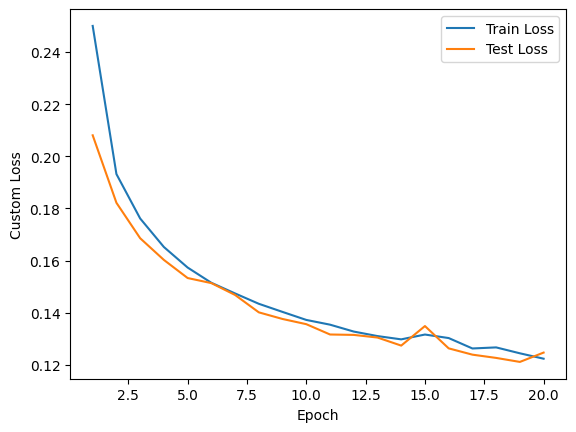

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.normal import Normal
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the dataset and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Initialize the RealNVP model and move it to GPU
height, width = 28, 28  # MNIST image dimensions
realnvp_model = RealNVP(height, width).to("cuda")

# Define the optimizer
optimizer = optim.Adam(realnvp_model.parameters(), lr=1e-4)

# Custom loss function
def loss_function(target_distribution, z, log_det_jacobian):
    log_likelihood = target_distribution.log_prob(z) + log_det_jacobian
    return -log_likelihood.mean()

# Training loop with tqdm
num_epochs = 20

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    realnvp_model.train()
    train_loss_epoch = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()

            # Move data to GPU
            data = data.to("cuda")

            # data = data[:, 0, :, :].unsqueeze(1)  # Use only one channel (grayscale)
            z, log_det_jacobian_total = realnvp_model(data)

            # Create a normal distribution for the target
            target_distribution = Normal(torch.zeros_like(z), torch.ones_like(z))

            loss = loss_function(target_distribution, z, log_det_jacobian_total)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item()

            pbar.update(1)
            pbar.set_postfix({'Loss': train_loss_epoch / (batch_idx + 1)})

    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)

    # Evaluate on the test set
    realnvp_model.eval()
    test_loss_epoch = 0.0

    with torch.no_grad(), tqdm(total=len(test_loader), desc=f'Test Loss', unit='batch') as pbar:
        for data, _ in test_loader:
            # Move data to GPU
            data = data.to("cuda")

            z, log_det_jacobian_total = realnvp_model(data)

            # Create a normal distribution for the target
            target_distribution = Normal(torch.zeros_like(z), torch.ones_like(z))

            loss = loss_function(target_distribution, z, log_det_jacobian_total)
            test_loss_epoch += loss.item()

            pbar.update(1)

    test_loss_epoch /= len(test_loader)
    test_losses.append(test_loss_epoch)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_epoch:.4f}, Test Loss: {test_loss_epoch:.4f}')

# Plot the training and test losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Custom Loss')
plt.legend()
plt.show()


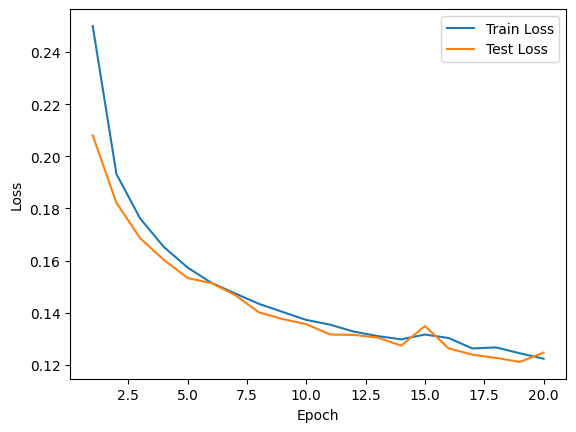

In [10]:
# Plot the training and test losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

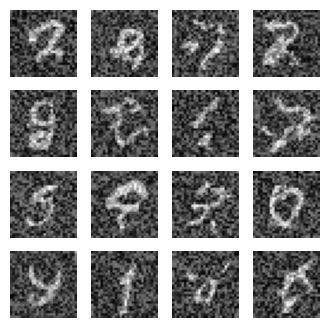

In [3]:
#Generate 16 images
realnvp_model.eval()

with torch.no_grad():
    # Generate random samples from a standard normal distribution
    z_samples = torch.randn(16, 1, height, width).to("cuda")

    # Decode the samples using the inverse function of the RealNVP model
    generated_images = realnvp_model.inverse(z_samples)

# Display the generated images
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 17.043013
Train Epoch: 1 [3200/60000 (5%)]	Loss: -15.170286
Train Epoch: 1 [6400/60000 (11%)]	Loss: -22.102001
Train Epoch: 1 [9600/60000 (16%)]	Loss: -22.940842
Train Epoch: 1 [12800/60000 (21%)]	Loss: -23.276806
Train Epoch: 1 [16000/60000 (27%)]	Loss: -24.204340
Train Epoch: 1 [19200/60000 (32%)]	Loss: -24.492970
Train Epoch: 1 [22400/60000 (37%)]	Loss: -25.168854
Train Epoch: 1 [25600/60000 (43%)]	Loss: -24.527401
Train Epoch: 1 [28800/60000 (48%)]	Loss: -25.848211
Train Epoch: 1 [32000/60000 (53%)]	Loss: -26.062397
Train Epoch: 1 [35200/60000 (59%)]	Loss: -25.387444
Train Epoch: 1 [38400/60000 (64%)]	Loss: -26.209446
Train Epoch: 1 [41600/60000 (69%)]	Loss: -26.513565
Train Epoch: 1 [44800/60000 (75%)]	Loss: -26.207367
Train Epoch: 1 [48000/60000 (80%)]	Loss: -26.638571
Train Epoch: 1 [51200/60000 (85%)]	Loss: -27.073284
Train Epoch: 1 [54400/60000 (91%)]	Loss: -27.089352
Train Epoch: 1 [57600/60000 (96%)]	Loss: -26.926779
====> Epoch: 1 Average

<Figure size 1600x1600 with 0 Axes>

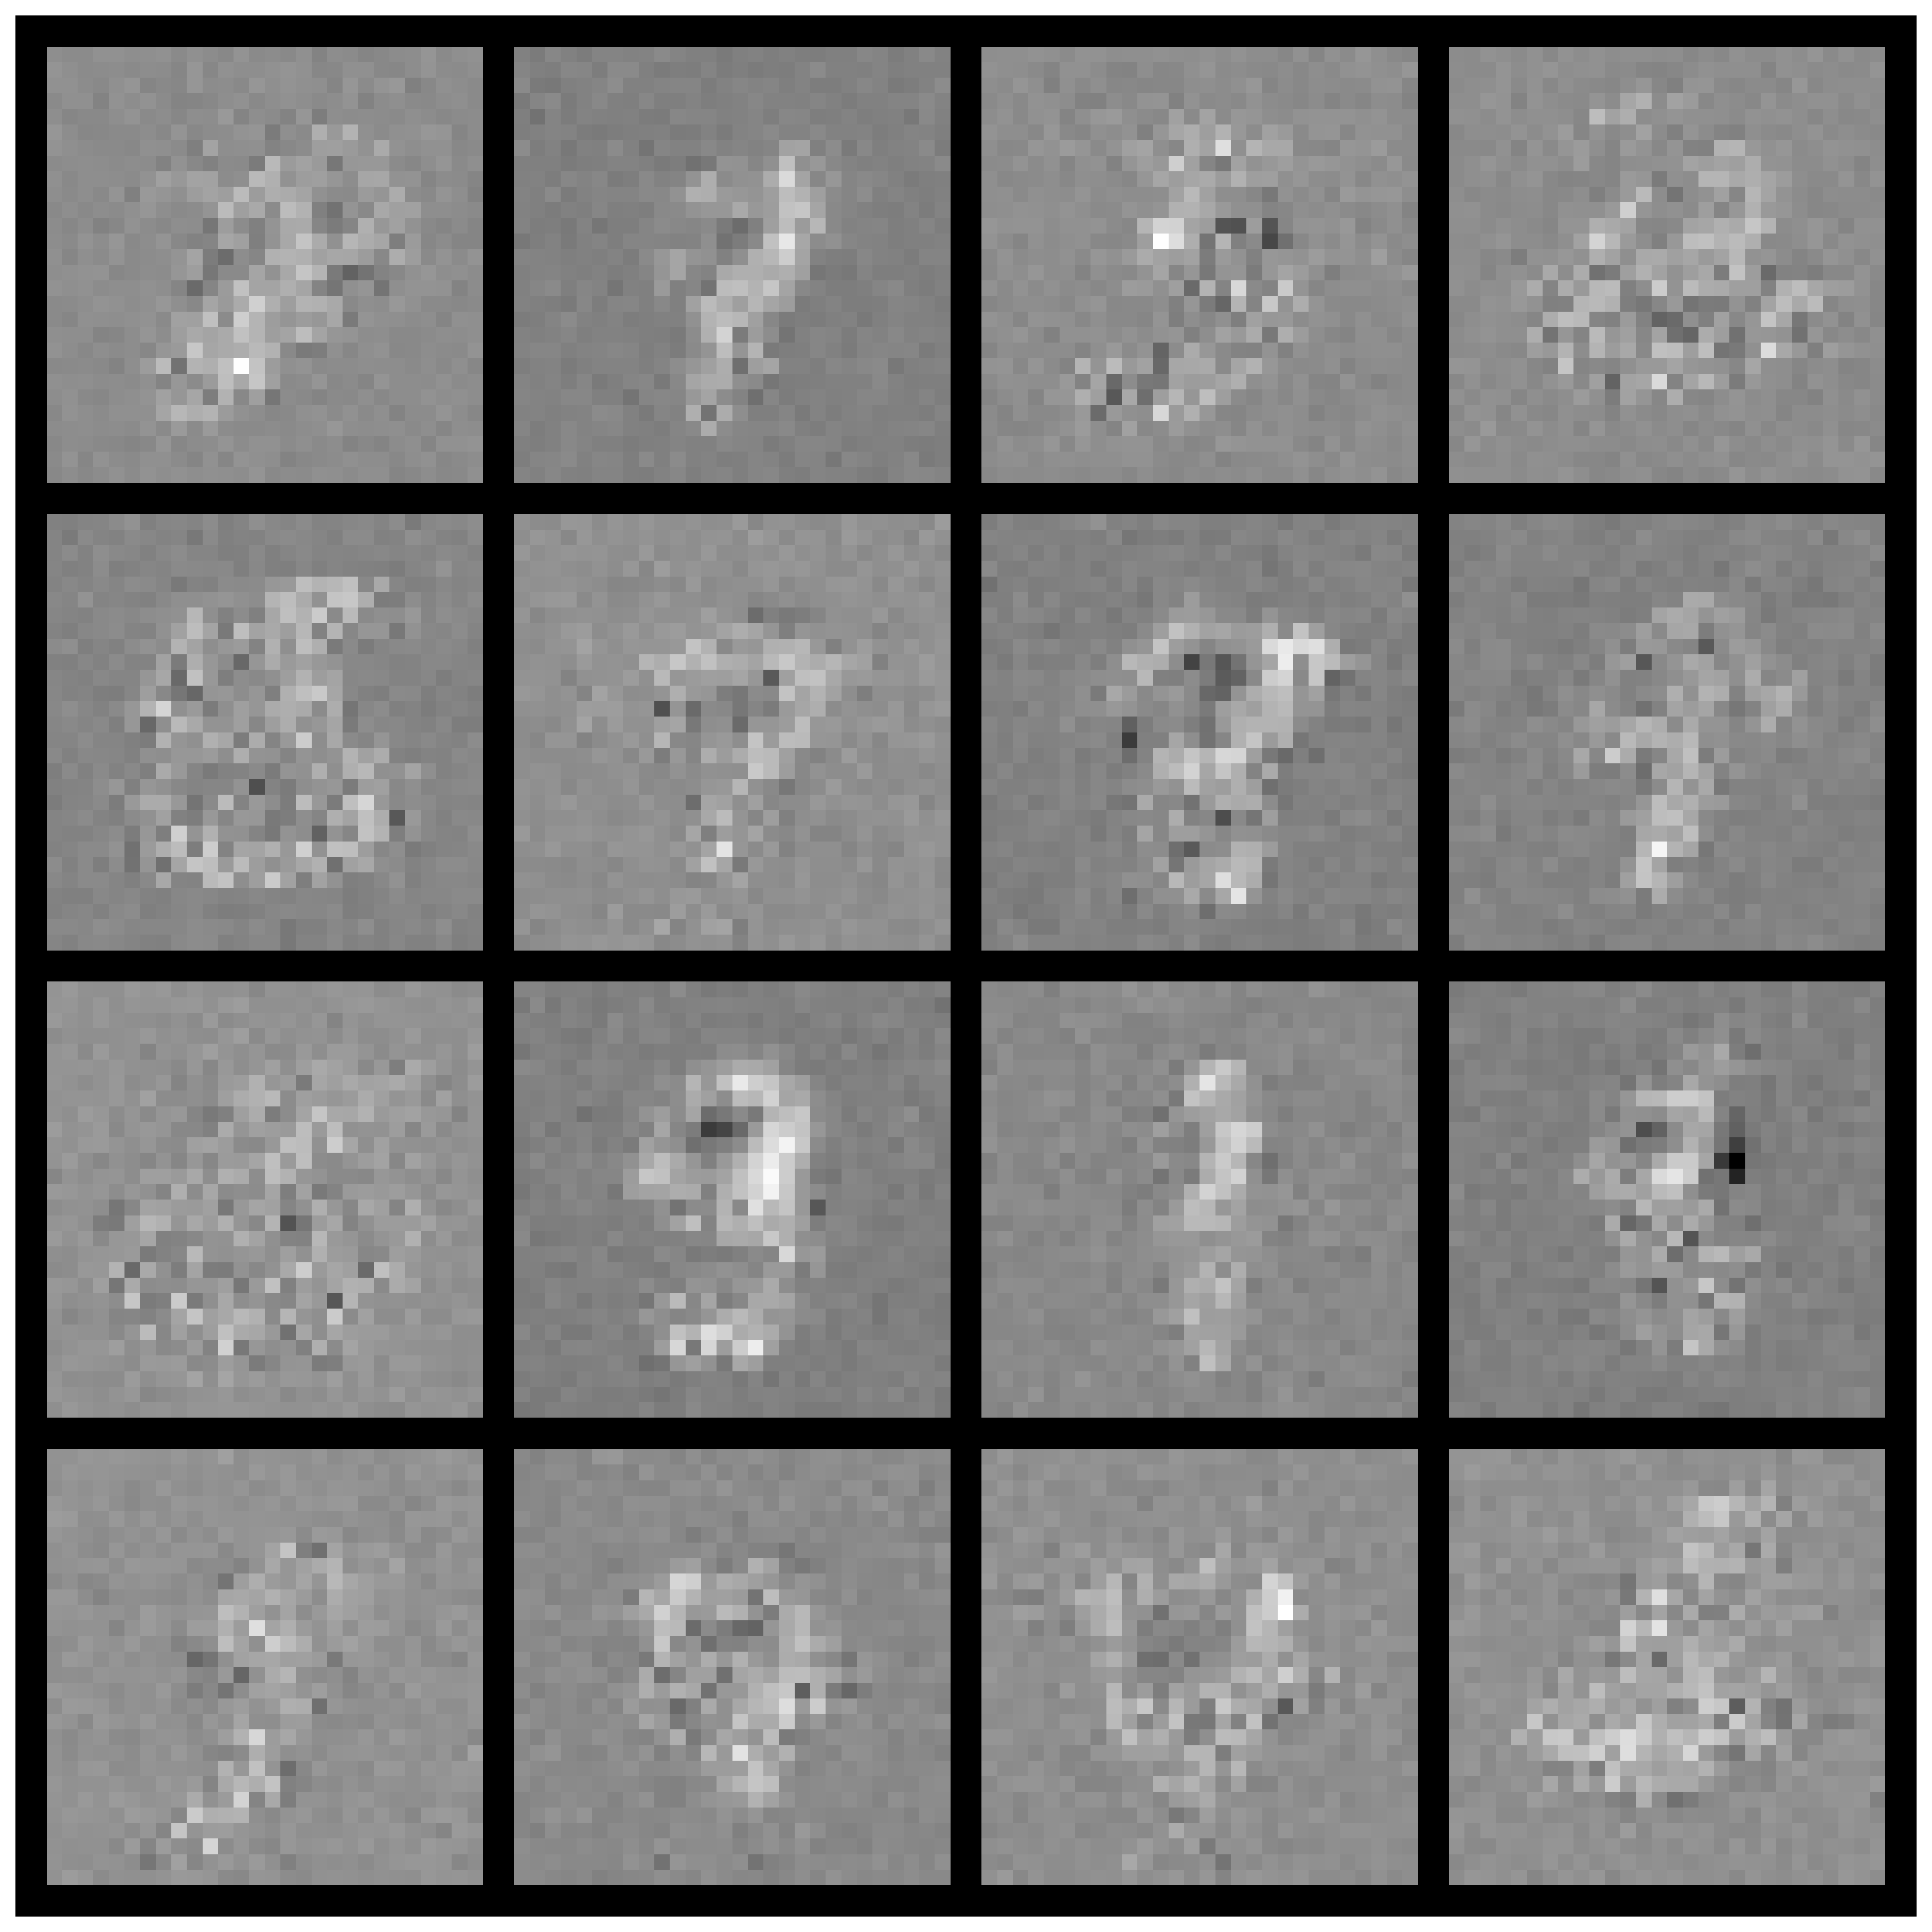

<Figure size 1600x1600 with 0 Axes>

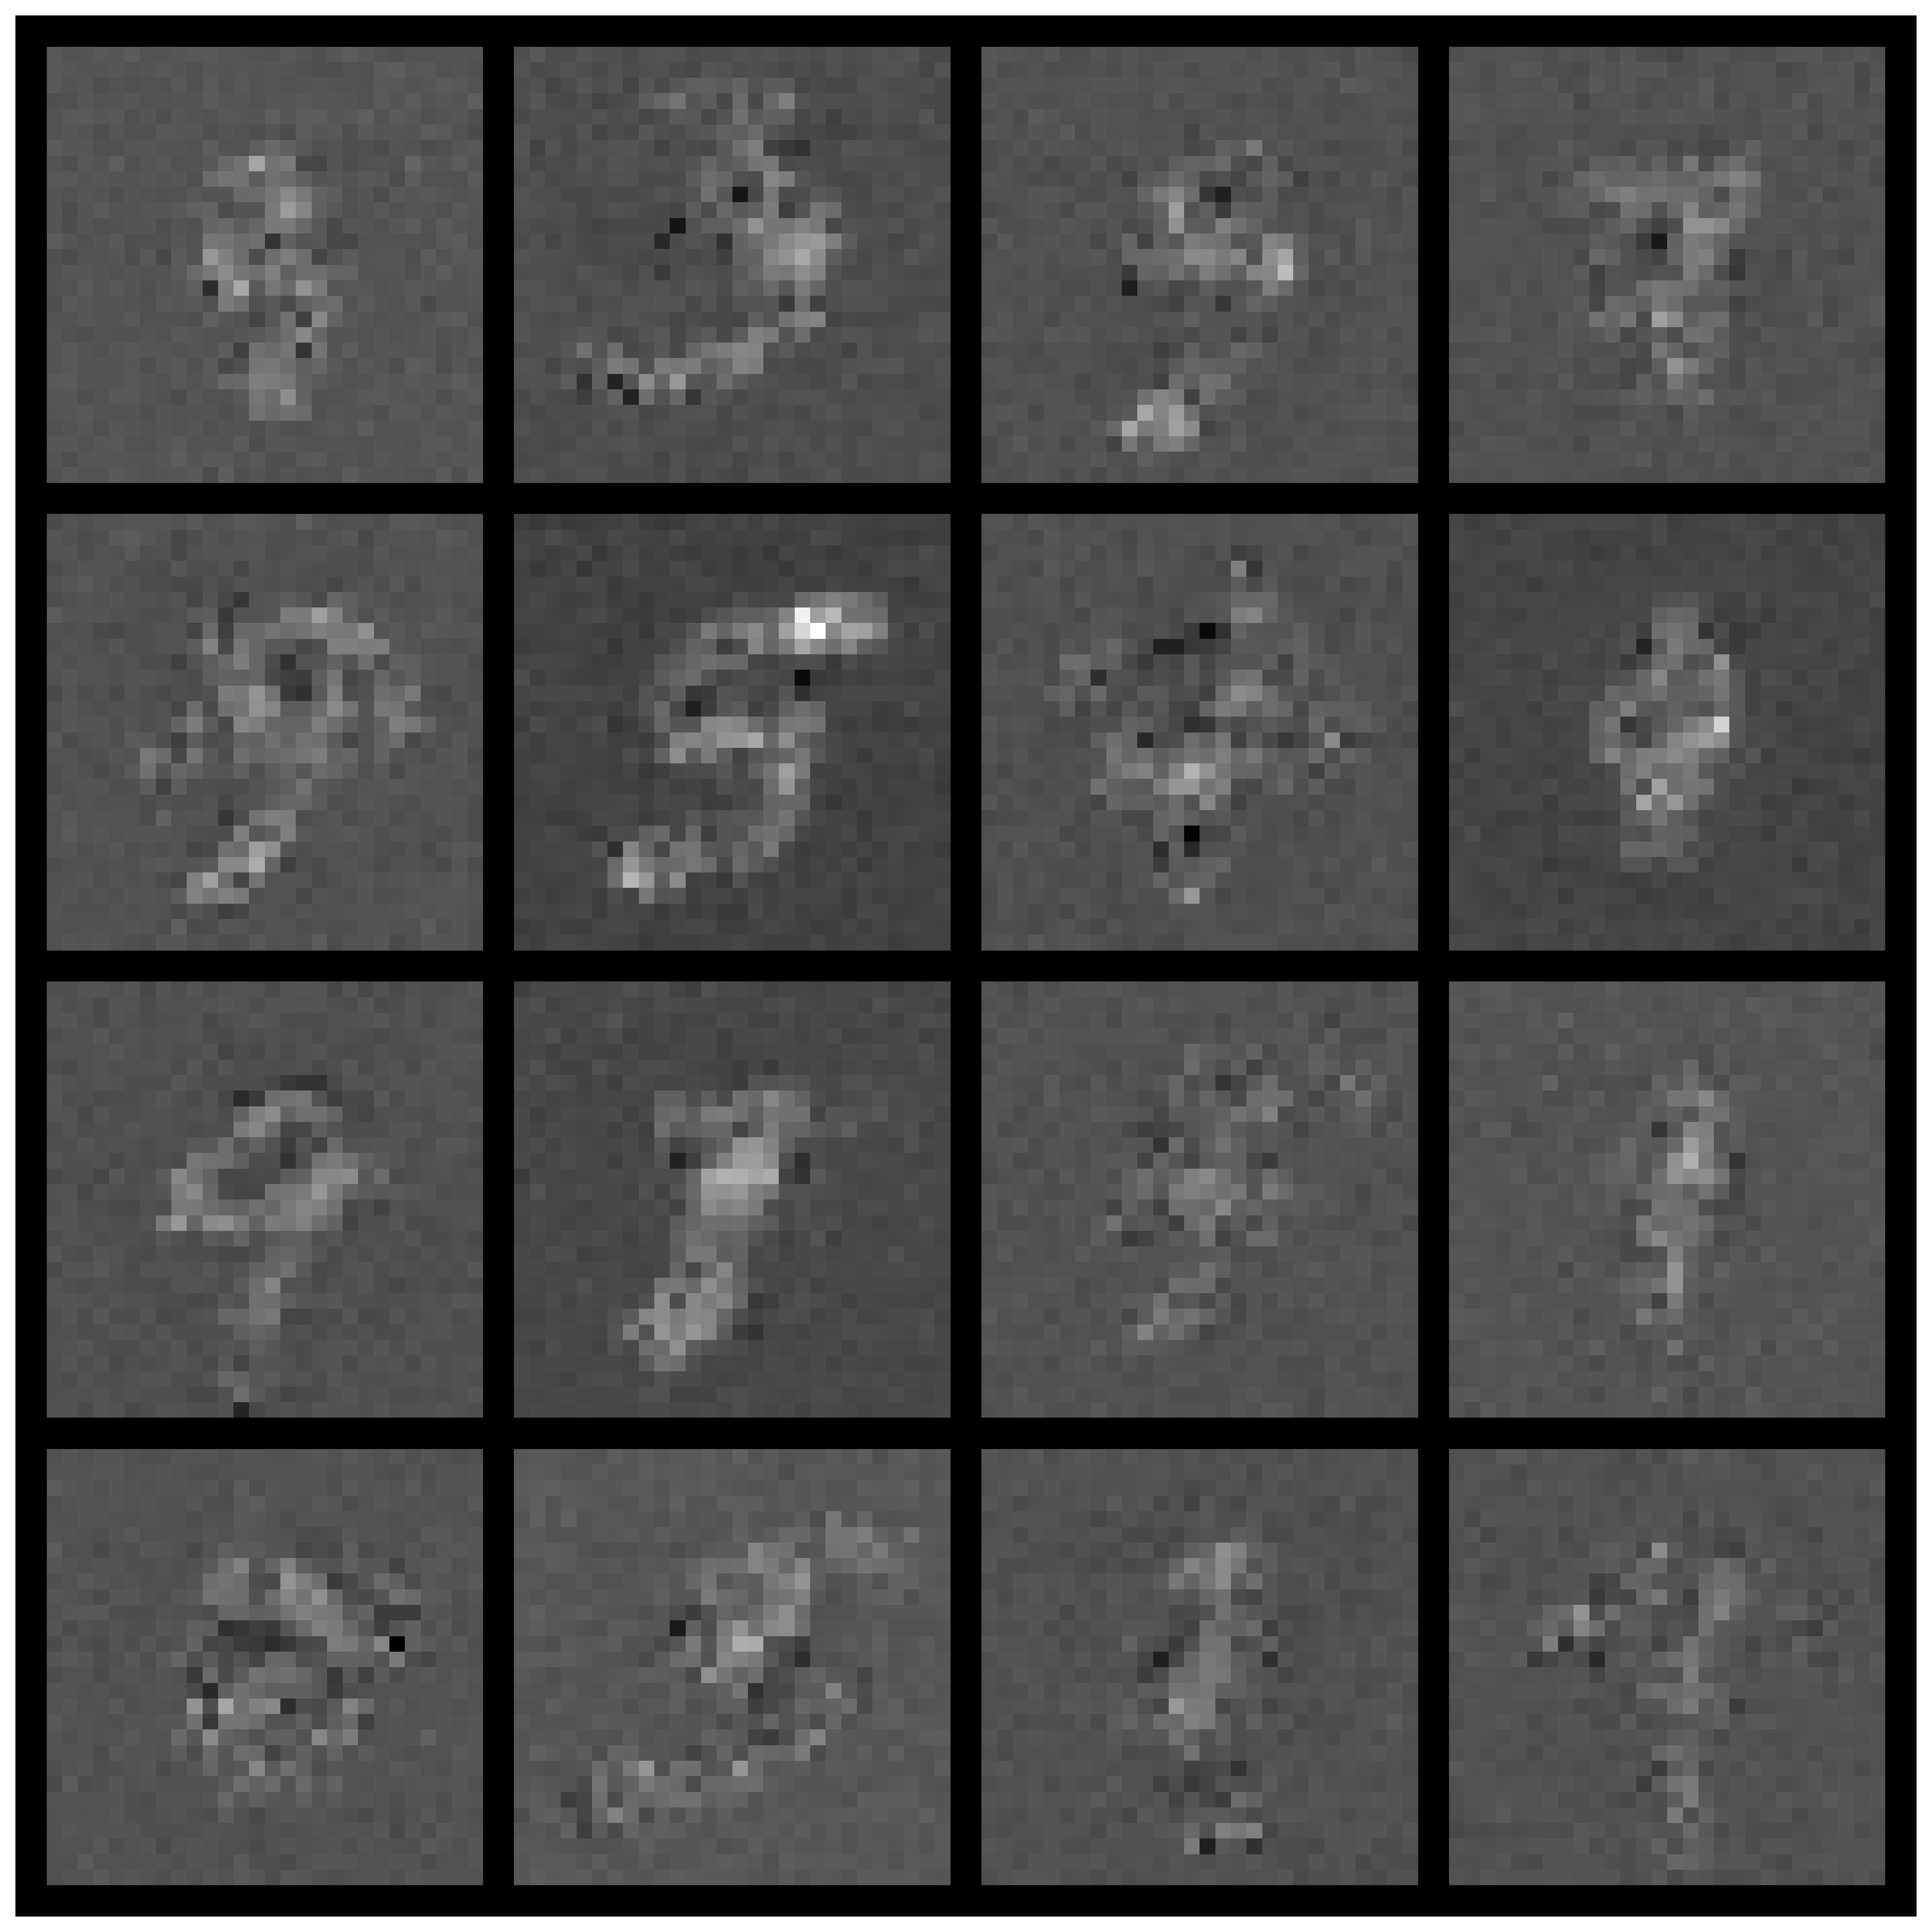

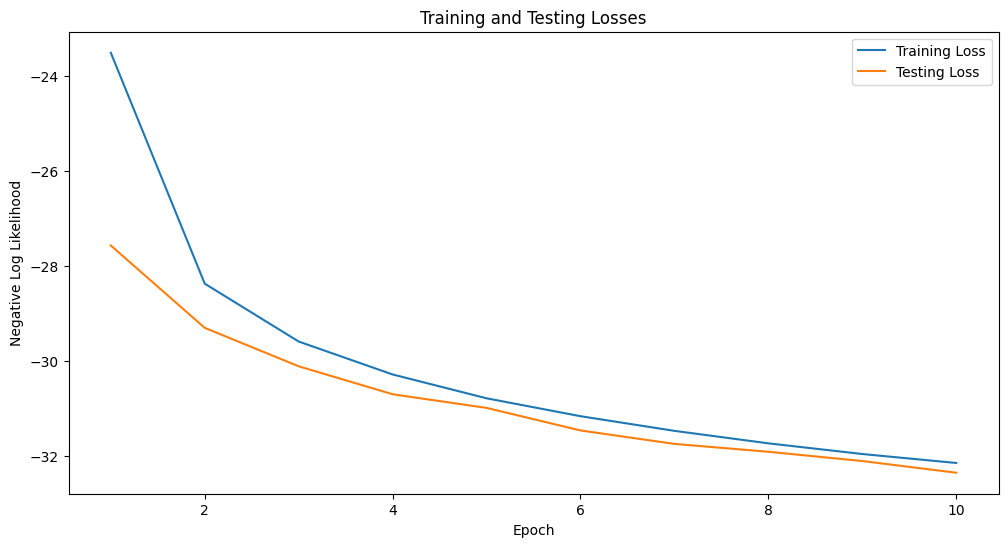

In [11]:
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import os

BATCH_SIZE = 64
LOGINTERVAL = 50
EPOCHS = 10
INPUT_DIM = 28 * 28  # MNIST images are 28x28 pixels
OUTPUT_DIM = 28 * 28
HIDDEN_DIM = 256
SAVE_PLT = 5
N_COUPLE_LAYERS = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- data loading --- #
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **kwargs)


# --- defines the model and the optimizer ---- #
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.mask = mask

    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian

    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x


class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0 # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z

mask = torch.from_numpy(np.zeros(INPUT_DIM).astype(np.float32))
mask[:INPUT_DIM//2] = 1.0
model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, mask, N_COUPLE_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(INPUT_DIM), torch.eye(INPUT_DIM))


# --- train and test --- #
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        optimizer.zero_grad()
        z, log_det_j_sum = model(data.view(-1, INPUT_DIM))
        loss = -(prior_z.log_prob(z) + log_det_j_sum).mean()
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % LOGINTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                cur_loss / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset)



def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):  # Assuming the MNIST DataLoader returns a tuple (data, labels)

            z, log_det_j_sum = model(data.view(-1, INPUT_DIM))
            cur_loss = -(prior_z.log_prob(z) + log_det_j_sum).mean().item()
            test_loss += cur_loss

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        return test_loss


if __name__ == '__main__':
    train_losses = []
    test_losses = []

    for epoch in range(1, EPOCHS + 1):
        train_loss = train(epoch)
        test_loss = test(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Save model checkpoint (optional)
        if epoch % SAVE_PLT == 0:
            torch.save(model.state_dict(), f'model_checkpoint_epoch_{epoch}.pth')

        # Generate and save 16 random images
        if epoch % SAVE_PLT == 0:
            with torch.no_grad():
                z_samples = prior_z.sample((16,))
                generated_samples = model.backward(z_samples).view(-1, 1, 28, 28)
                plt.figure(figsize=(16, 16))

        # Assuming save_image uses matplotlib under the hood
                save_image(generated_samples, 'temp_generated_samples.png', nrow=4, normalize=True)

        # Load the saved image using Matplotlib and then save it with a higher dpi
                img = plt.imread('temp_generated_samples.png')
                plt.figure(figsize=(16, 16), dpi=300)
                plt.imshow(img)
                plt.axis('off')
                plt.savefig(f'generated_samples_epoch_{epoch}.png', bbox_inches='tight', pad_inches=0)

        # Remove the temporary file
                os.remove('temp_generated_samples.png')

    # Plot training and testing losses
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Training and Testing Losses')
    plt.savefig('training_testing_losses.png')
    plt.show()
